# **XAI4Spectra**

# **Loading data**

In [1]:
# importing the necessary libraries
import pandas as pd
import numpy as np
import kennard_stone as ks

# loading a soil spectral dataset based on X-ray fluorescence (XRF)
#data_complete = pd.read_csv('https://raw.githubusercontent.com/joseviniciusr/XAI4Spectra/main/XRFspectra.csv', sep=';') # Toledo 2022 dataset
data_complete = pd.read_csv('XRFspectra.csv', sep=';') # local copy of Toledo 2022 dataset
data = data_complete.loc[:, '1':'15']
data.insert(0, 'exCa', data_complete['exCa'])  # inserting the target variable (e.g., exCa (exchangeable calcium))

## **PLS- (R or DA) modeling**

In [2]:
def vip_scores(pls_model):
    """
    Calculate VIP (Variable Importance in Projection) scores for a fitted PLS model.
    Parameters
    ----------
    - **pls_model** : fitted PLS model object from sklearn.cross_decomposition.PLSRegression
        The PLS model for which to calculate VIP scores.
    Returns
    -------
    - vip_scores : ndarray, shape (n_features,)
        VIP scores for each feature in the model.
    """
    import numpy as np

    t = pls_model.x_scores_ # X scores 
    w = pls_model.x_weights_ # X weights
    p = pls_model.y_loadings_ # Y loadings
    features, _ = w.shape # number of features
    vip = np.zeros(shape=(features,)) # initializing VIP scores array
    inner_sum = np.diag(t.T @ t @ p.T @ p) # inner sum calculation
    SS_total = np.sum(inner_sum) # total sum of squares
    vip = np.sqrt(features*(w**2 @ inner_sum)/ SS_total) # VIP calculation
    return pd.DataFrame(vip)

def explained_variance_from_scores(X, T, P, Q=None, Y=None):
    """
    Calculate percent variance explained (based on PCTVAR Matlab function) for X and Y
    by using the scores T and loadings P (and optionally Q for Y).
    Parameters
    ----------
    - **X** : array-like, shape (n_samples, n_features)
        X matrix used in PLS.
    - **T** : array-like, shape (n_samples, n_components)
        Scores matrix from PLS.
    - **P** : array-like, shape (n_features, n_components)
        Loadings matrix for X from PLS.
    - **Q** : array-like, shape (n_targets, n_components), optional
        Loadings matrix for Y from PLS. Required if Yc is provided.
    - **Y** : array-like, shape (n_samples, n_targets), optional
       Y matrix used in PLS.
    Returns
    -------
    - result : dict with keys:
        - **'varX_cumulative'** : ndarray shape (n_components,)
            Percent cumulative variance of X explained by 1..j components.
        - **'varX_per_component'** : ndarray shape (n_components,)
            Percent variance of X explained per component.
        - **'varY_cumulative'** : ndarray shape (n_components,), or None
            Percent cumulative variance of Y explained by 1..j components (if Yc and Q provided).
        - **'varY_per_component'** : ndarray shape (n_components,), or None
            Percent variance of Y explained per component (if Yc and Q provided).
    """
    import numpy as np
    X = np.asarray(X, dtype=float) # X preprocessed data
    T = np.asarray(T, dtype=float) # scores
    P = np.asarray(P, dtype=float) # loadings for X

    n_comp = T.shape[1]
    TSS_X = np.sum(X ** 2) # total sum of squares of X
    if TSS_X == 0: # avoid division by zero
        raise ValueError("TSS_X == 0 (X does not have variability).")

    pctvarX_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for X

    for j in range(1, n_comp + 1): # loop over components
        Xhat_j = T[:, :j] @ P[:, :j].T # reconstructed X using j components
        SS_Xhat_j = np.sum(Xhat_j ** 2) # sum of squares of reconstructed X
        pctvarX_cum[j-1] = 100.0 * SS_Xhat_j / TSS_X # percent variance explained cumulativa
    
    # incremental (per component)
    pctvarX_per = np.empty_like(pctvarX_cum) # incremental percent variance for X
    pctvarX_per[0] = pctvarX_cum[0] # first component
    pctvarX_per[1:] = pctvarX_cum[1:] - pctvarX_cum[:-1] # rest

    # Y (if provided)
    pctvarY_cum = None # cumulative percent variance for Y
    pctvarY_per = None # incremental percent variance for Y
    if Q is not None and Y is not None: # if Y loadings and Y centered provided
        Q = np.asarray(Q, dtype=float) # loadings for Y
        Y = np.asarray(Y, dtype=float) # centered (and possibly scaled) Y
        TSS_Y = np.sum(Y ** 2) # total sum of squares of Y
        if TSS_Y == 0: # avoid division by zero
            pctvarY_cum = np.zeros(n_comp, dtype=float) # all zeros if Y has no variance
            pctvarY_per = np.zeros(n_comp, dtype=float) # all zeros
        else:
            pctvarY_cum = np.zeros(n_comp, dtype=float) # cumulative percent variance for Y
            for j in range(1, n_comp + 1): # loop over components
                Yhat_j = T[:, :j] @ Q[:, :j].T # reconstructed Y using j components
                SS_Yhat_j = np.sum(Yhat_j ** 2) # sum of squares of reconstructed Y
                pctvarY_cum[j-1] = 100.0 * SS_Yhat_j / TSS_Y # percent variance explained cumulativa
            pctvarY_per = np.empty_like(pctvarY_cum) # incremental percent variance for Y
            pctvarY_per[0] = pctvarY_cum[0] # first component
            pctvarY_per[1:] = pctvarY_cum[1:] - pctvarY_cum[:-1] # rest

        return {
            'varX_cumulative': pctvarX_cum[-1],
            'varX_per_component': pctvarX_per[-1],
            'varY_cumulative': pctvarY_cum[-1],
            'varY_per_component': pctvarY_per[-1]
            }         


def pls_optimized(Xcal, ycal, LVmax, Xpred=None, ypred=None, aim='regression', cv=10):
    """
    ## PLS optimized
    Function to fit a PLS regression or PLS-DA model with optimization of latent variables (LVs)
    using cross-validation. It calculates various performance metrics for calibration, cross-validation,
    and prediction (if provided) datasets
    **Parameters**:
    - **Xcal** : pd.DataFrame
        Calibration dataset features.
    - **ycal** : pd.Series or np.ndarray
        Calibration dataset target variable (regression) or binary class labels (classification).
    - **LVmax** : int
        Maximum number of latent variables to consider.
    - **Xpred** : pd.DataFrame, optional
        Prediction dataset features. Default is None.
    - **ypred** : pd.Series or np.ndarray, optional
        Prediction dataset target variable (regression) or binary class labels (classification). Default is None.
    - **aim** : str, optional
        Type of analysis: 'regression' for PLS regression or 'classification' for PLS-DA. Default is 'regression'.
    - **cv** : int, optional
        Number of cross-validation folds. Default is 10
        
    **Returns**:
    - **df_results** : pd.DataFrame
        DataFrame containing performance metrics for each number of latent variables.
    - **calres** : pd.DataFrame
        DataFrame containing predicted values for the calibration dataset.
    - **predres** : pd.DataFrame
        DataFrame containing predicted values for the prediction dataset (if provided).
    """

    import numpy as np
    import pandas as pd

    if aim == 'regression': # regression (PLSR)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import mean_squared_error, r2_score
        from scipy.stats import iqr

        results = [] # list to store results for each LV
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsr = PLSRegression(n_components=n_comp, scale=False)
            plsr.fit(Xcal, ycal)
            y_cal = plsr.predict(Xcal).flatten()
            calres[f'LV_{n_comp}'] = y_cal

            y_cv = cross_val_predict(plsr, Xcal, ycal, cv=cv) # cross-validated predictions
            y_cv = np.array(y_cv).flatten()

            R2_cal = r2_score(ycal, y_cal) # determination coefficient
            r2_cal = np.corrcoef(ycal, y_cal)[0, 1] ** 2 # correlation coefficient squared
            rmse_cal = np.sqrt(mean_squared_error(ycal, y_cal))
            R2_cv = r2_score(ycal, y_cv)
            r2_cv = np.corrcoef(ycal, y_cv)[0, 1] ** 2
            rmsecv = np.sqrt(mean_squared_error(ycal, y_cv))
            rpd_cv = ycal.std() / rmsecv if rmsecv != 0 else np.nan
            rpiq_cv = iqr(ycal, rng=(25, 75)) / rmsecv if rmsecv != 0 else np.nan
            bias_cv = np.sum(ycal - y_cv) / ycal.shape[0]
            SDV_cv = (ycal - y_cv) - bias_cv
            SDV_cv = np.sqrt(np.sum(SDV_cv * SDV_cv) / (ycal.shape[0] - 1)) if ycal.shape[0] > 1 else np.nan
            tbias_cv = abs(bias_cv) * (np.sqrt(ycal.shape[0]) / SDV_cv) if SDV_cv not in (0, np.nan) else np.nan
            
            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsr.x_scores_, plsr.x_loadings_,
                                               Q=plsr.y_loadings_, Y=ycal) # explained variance
            
            # vip scores
            vip = vip_scores(plsr).T
            vip.columns = plsr.feature_names_in_ # setting feature names

            if Xpred is not None and ypred is not None: # prediction set
                y_pred = plsr.predict(Xpred).flatten()
                predres[f'LV_{n_comp}'] = y_pred

                R2_pred = r2_score(ypred, y_pred) # determination coefficient
                r2_pred = np.corrcoef(ypred, y_pred)[0, 1] ** 2 # correlation coefficient squared
                rmsep = np.sqrt(mean_squared_error(ypred, y_pred))
                rpd_pred = ypred.std() / rmsep if rmsep != 0 else np.nan
                rpiq_pred = iqr(ypred, rng=(25, 75)) / rmsep if rmsep != 0 else np.nan
                bias_pred = np.sum(ypred - y_pred) / ypred.shape[0]
                SDV_pred = (ypred - y_pred) - bias_pred
                SDV_pred = np.sqrt(np.sum(SDV_pred * SDV_pred) / (ypred.shape[0] - 1)) if ypred.shape[0] > 1 else np.nan
                tbias_pred = abs(bias_pred) * (np.sqrt(ypred.shape[0]) / SDV_pred) if SDV_pred not in (0, np.nan) else np.nan
            else:
                r2_pred = rmsep = rpd_pred = rpiq_pred = bias_pred = tbias_pred = None

            results.append({
                'LVs': n_comp,
                'R2_Cal': R2_cal,
                'r2_Cal': r2_cal,
                'RMSEC': rmse_cal,
                'R2_CV': R2_cv,
                'r2_Cv': r2_cv,
                'RMSECV': rmsecv,
                'RPD_CV': rpd_cv,
                'RPIQ_CV': rpiq_cv,
                'Bias_CV': bias_cv,
                'tbias_CV': tbias_cv,
                'R2_Pred': R2_pred,
                'r2_Pred': r2_pred,
                'RMSEP': rmsep,
                'RPD_Pred': rpd_pred,
                'RPIQ_Pred': rpiq_pred,
                'Bias_Pred': bias_pred,
                'tbias_Pred': tbias_pred,
                'X_Cum_Exp_Var' : exp_var['varX_cumulative'],
                'Y_Cum_Exp_Var' : exp_var['varY_cumulative'],
                'X_Ind_Exp_Var' : exp_var['varX_per_component'],
                'Y_Ind_Exp_Var' : exp_var['varY_per_component']
            })

        model = plsr  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    elif aim == 'classification': # classification (PLS-DA)
        from sklearn.cross_decomposition import PLSRegression
        from sklearn.model_selection import cross_val_predict
        from sklearn.metrics import accuracy_score, confusion_matrix

        results = []
        calres = pd.DataFrame(index=range(len(ycal))) # calibration results
        predres = pd.DataFrame(index=range(len(ypred))) if (Xpred is not None and ypred is not None) else None # prediction results

        # ensure binary classes
        ycal_series = pd.Series(ycal).reset_index(drop=True) # ensure it's a Series
        unique_labels = ycal_series.unique() # unique class labels
        if len(unique_labels) != 2: # check for binary classification
            raise ValueError(f"PLS-DA (this function) expects 2 classes (binary). Found: {unique_labels}")

        label_to_num = {lab: idx for idx, lab in enumerate(unique_labels)} # mapping labels to 0 and 1
        num_to_label = {idx: lab for lab, idx in label_to_num.items()} # reverse mapping for predictions
       
        # prepare ycal numeric
        ycal_numeric = np.array([label_to_num[i] for i in ycal]) 

        # prepare ypred numeric if provided
        ypred_numeric = None
        if ypred is not None:
            ypred_numeric = np.array([label_to_num[i] for i in ypred])

        for n_comp in range(1, LVmax + 1): # loop over number of components
            plsda = PLSRegression(n_components=n_comp, scale=False)
            plsda.fit(Xcal, ycal_numeric)

            # calibration continuous predictions -> binarize
            y_cal_cont = plsda.predict(Xcal).flatten()
            y_cal_bin = (y_cal_cont >= 0.5).astype(int)
            y_cal_class = np.array([num_to_label[i] for i in y_cal_bin])
            calres[f'LV_{n_comp}'] = y_cal_class
            calres_numeric = pd.DataFrame(y_cal_cont, columns=[f'LV_{n_comp}']) # numeric calibration results

            # cross-validated continuous predictions -> binarize
            y_cv_cont = cross_val_predict(plsda, Xcal, ycal_numeric, cv=cv)
            y_cv_cont = np.array(y_cv_cont).flatten()
            y_cv_bin = (y_cv_cont >= 0.5).astype(int)

            # metrics
            acc_cal = accuracy_score(ycal_numeric, y_cal_bin)
            cm_cal = confusion_matrix(ycal_numeric, y_cal_bin)
            # safe unpack for binary confusion matrix
            if cm_cal.size == 4:
                tn, fp, fn, tp = cm_cal.ravel()
            else:
                tn = fp = fn = tp = np.nan
            sensitivity = tp / (tp + fn) if (tp + fn) > 0 else np.nan
            specificity = tn / (tn + fp) if (tn + fp) > 0 else np.nan

            acc_cv = accuracy_score(ycal_numeric, y_cv_bin)
            cm_cv = confusion_matrix(ycal_numeric, y_cv_bin)
            if cm_cv.size == 4:
                tn_cv, fp_cv, fn_cv, tp_cv = cm_cv.ravel()
            else:
                tn_cv = fp_cv = fn_cv = tp_cv = np.nan
            sensitivity_cv = tp_cv / (tp_cv + fn_cv) if (tp_cv + fn_cv) > 0 else np.nan
            specificity_cv = tn_cv / (tn_cv + fp_cv) if (tn_cv + fp_cv) > 0 else np.nan

            # explained variance
            exp_var = explained_variance_from_scores(Xcal, plsda.x_scores_, plsda.x_loadings_,
                                               Q=plsda.y_loadings_, Y=ycal_numeric.reshape(-1, 1)) # explained variance

            # vip scores
            vip = vip_scores(plsda).T
            vip.columns = plsda.feature_names_in_ # setting feature names

            # prediction set (if provided)
            if Xpred is not None and ypred is not None:
                y_pred_cont = plsda.predict(Xpred).flatten()
                y_pred_bin = (y_pred_cont >= 0.5).astype(int)
                y_pred_class = np.array([num_to_label[i] for i in y_pred_bin])
                predres[f'LV_{n_comp}'] = y_pred_class
                predres_numeric = pd.DataFrame(y_pred_cont, columns=[f'LV_{n_comp}']) # numeric prediction results

                acc_pred = accuracy_score(ypred_numeric, y_pred_bin)
                cm_pred = confusion_matrix(ypred_numeric, y_pred_bin)
                if cm_pred.size == 4:
                    tn_p, fp_p, fn_p, tp_p = cm_pred.ravel()
                else:
                    tn_p = fp_p = fn_p = tp_p = np.nan
                sensitivity_p = tp_p / (tp_p + fn_p) if (tp_p + fn_p) > 0 else np.nan
                specificity_p = tn_p / (tn_p + fp_p) if (tn_p + fp_p) > 0 else np.nan
            else:
                acc_pred = sensitivity_p = specificity_p = cm_pred = tn_p = fp_p = fn_p = tp_p = None

            results.append({
                'LVs': n_comp,
                'Accuracy Cal': acc_cal,
                'Sensitivity Cal': sensitivity,
                'Specificity Cal': specificity,
                'CM Cal': cm_cal,
                'Accuracy CV': acc_cv,
                'Sensitivity CV': sensitivity_cv,
                'Specificity CV': specificity_cv,
                'CM CV': cm_cv,
                'Accuracy Pred': acc_pred,
                'Sensitivity Pred': sensitivity_p,
                'Specificity Pred': specificity_p,
                'CM Pred': cm_pred,
                'X Cum Exp Var' : exp_var['varX_cumulative'],
                'Y Cum Exp Var' : exp_var['varY_cumulative'],
                'X Ind Exp Var' : exp_var['varX_per_component'],
                'Y Ind Exp Var' : exp_var['varY_per_component']
            })

        model = plsda  # last model fitted
        df_results = pd.DataFrame(results)
        calres.insert(0, 'Ref', np.array(ycal))
        if predres is not None:
            predres.insert(0, 'Ref', np.array(ypred))

    else:
        raise ValueError("Parameter `aim` must be 'regression' or 'classification'.")

    return df_results, calres, predres, model, vip, calres_numeric, predres_numeric

In [3]:
def extract_spectral_zones(Xcal, cuts):
    """
    Extract spectral zones from a DataFrame based on specified cuts.
    
    Parameters
    ----------
    - **Xcal** : pd.DataFrame
        DataFrame with spectral data, where columns are wavelengths/energies.
    - **cuts** : list of tuples/lists or dicts
        Each item defines a spectral zone to extract.
        - If tuple/list: (start, end) or (name, start, end)
        - If dict: {'name': str, 'start': float, 'end': float}
    
    Returns
    -------
    - **zones** : dict
        Dictionary where keys are zone names and values are DataFrames with the extracted spectral zones.
    """
    import numpy as np
    import pandas as pd

    # convert the column names to numeric when possible (NaN when not convertible)
    col_nums = pd.to_numeric(Xcal.columns.astype(str), errors='coerce')
    zones = {} # dictionary to store extracted zones

    for cut in cuts:
        # normalize cut format
        if isinstance(cut, dict): # if dict
            name = cut.get('name', f"{cut.get('start')}-{cut.get('end')}") # default name if not provided
            start = cut.get('start') # getting start value
            end = cut.get('end') # getting end value
        elif isinstance(cut, (list, tuple)): # if list/tuple
            if len(cut) == 2: 
                start, end = cut # getting start and end values
                name = f"{start}-{end}" # default name
            elif len(cut) == 3: # if name provided
                name, start, end = cut # getting name, start and end values
            else:
                raise ValueError("Cuts in tuple/list format must have 2 or 3 elements.")
        else:
            raise ValueError("Each cut must be a dict or a tuple/list.")

        # validate start and end
        try:
            s = float(start)
            e = float(end)
        except Exception: # Exception for conversion errors
            raise ValueError("star and end must be numeric values (int/float or convertible strings).")

        if s > e: # swap if necessary
            s, e = e, s

        # to select columns whose numeric value is in the interval [s, e]
        mask = (~np.isnan(col_nums)) & (col_nums >= s) & (col_nums <= e)
        selected_cols = list(Xcal.columns[mask])

        # piecing the zone DataFrame into the dictionary
        zones[name] = Xcal.loc[:, selected_cols]

    return zones

# **Classification case**

In [4]:
# Creating a new column 'Class' based on the condition of 'BSP' values
data_complete['Class'] = np.where(data_complete['BSP'] > 50.00, 'eut', 'dist') # eutrophic (eut) if BSP > 50.00 (higher fertility), otherwise dystrophic (dist)
data_eut = data_complete[data_complete['Class'] == 'eut'].reset_index(drop=True)
data_dist = data_complete[data_complete['Class'] == 'dist'].reset_index(drop=True)

In [5]:
# splitting the data into calibration and prediction sets by kennard-stone algorithm
Xeut_cal, Xeut_pred = ks.train_test_split(data_eut.loc[:, '1':'15'], test_size=0.30) # class eutrophic
Xeut_cal = Xeut_cal.reset_index(drop=True)
Xeut_pred = Xeut_pred.reset_index(drop=True)

Xdist_cal, Xdist_pred = ks.train_test_split(data_dist.loc[:, '1':'15'], test_size=0.30) # class dystrophic
Xdist_cal = Xdist_cal.reset_index(drop=True)
Xdist_pred = Xdist_pred.reset_index(drop=True)

Xcalclass = pd.concat([Xeut_cal, Xdist_cal], axis=0).reset_index(drop=True) # concatenating both classes
Xpredclass = pd.concat([Xeut_pred, Xdist_pred], axis=0).reset_index(drop=True)
ycalclass = pd.Series(['eut']*Xeut_cal.shape[0] + ['dist']*Xdist_cal.shape[0]) # creating the target variable for calibration set
ypredclass = pd.Series(['eut']*Xeut_pred.shape[0] + ['dist']*Xdist_pred.shape[0]) # creating the target variable for prediction set

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-20 09:14:36,493 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-20 09:14:36,507 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.



C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-20 09:14:36,548 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-11-20 09:14:36,557 - kennard_stone.utils._pairwise:109[INFO] - Calculating pairwise distances using scikit-learn.

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\sklearn\utils\deprecation.py:151: Futur

In [6]:
pd.options.plotting.backend = 'plotly' # setting plotly as the backend for pandas plotting 
Xcalclass.T.plot() # easily plotting the spectra 

In [7]:
# preprocessings
import preprocessings as prepr # preprocessing methods for XRF data

Xcalclass_prep, mean_calclass, mean_calclass_poisson  = prepr.poisson(Xcalclass, mc=True)
Xpredclass_prep = ((Xpredclass/np.sqrt(mean_calclass)) - mean_calclass_poisson)

In [8]:
# performing PLS-DA with optimized latent variables
plsda_results = pls_optimized(Xcalclass_prep, 
                              ycalclass,
                              LVmax=4,
                              Xpred=Xpredclass_prep,
                              ypred=ypredclass,
                              aim='classification',
                              cv=10)
plsda_results[0]

LVs  Accuracy Cal  Sensitivity Cal  Specificity Cal                CM Cal  \
0    1      0.804054         0.845070         0.766234  [[59, 18], [11, 60]]   
1    2      0.851351         0.915493         0.792208   [[61, 16], [6, 65]]   
2    3      0.831081         0.901408         0.766234   [[59, 18], [7, 64]]   
3    4      0.871622         0.887324         0.857143   [[66, 11], [8, 63]]   

   Accuracy CV  Sensitivity CV  Specificity CV                 CM CV  \
0     0.722973        0.746479        0.701299  [[54, 23], [18, 53]]   
1     0.810811        0.873239        0.753247   [[58, 19], [9, 62]]   
2     0.797297        0.845070        0.753247  [[58, 19], [11, 60]]   
3     0.770270        0.845070        0.701299  [[54, 23], [11, 60]]   

   Accuracy Pred  Sensitivity Pred  Specificity Pred              CM Pred  \
0       0.750000          0.870968          0.636364  [[21, 12], [4, 27]]   
1       0.843750          0.967742          0.727273   [[24, 9], [1, 30]]   
2       0.828125          0.967742          0.696970  [[23, 10], [1, 30]]   
3       0.875000          0.967742          0.787879   [[26, 7], [1, 30]]   

   X Cum Exp Var  Y Cum Exp Var  X Ind Exp Var  Y Ind Exp Var  
0      24.084452      18.486320      24.084452      18.486320  
1      46.025807      20.883518      21.941354       2.397198  
2      70.291459      21.960174      24.265653       1.076656  
3      78.655943      24.395837       8.364483       2.435663

In [9]:
plsda_results[3].feature_names_in_.shape

(701,)

In [10]:
reg_vet = pd.DataFrame(plsda_results[3].coef_, columns=plsda_results[3].feature_names_in_) # creating a DataFrame with regression coefficients
reg_vet.T.plot()

In [43]:
# establishing spectral cuts based on expert knowledge of XRF spectra
spectral_cuts = [
('Al', 1.38, 1.60),
('Si', 1.64, 1.84),
('P', 1.94, 2.10),
('S', 2.20, 2.44),
('Rh L + Ar', 2.56, 3.10),
('K', 3.22, 3.42),
('Ca ka', 3.58, 3.82),
('Ca kb', 3.92, 4.14),
('Ti ka', 4.38, 4.66),
('Ti kb', 4.82, 5.06),
('Mn', 5.78, 6.02),
('Fe ka', 6.26, 6.56),
('Fe kb', 6.92, 7.22),
('Cu', 7.92, 8.20)
]

In [44]:
spectral_zones_class = extract_spectral_zones(Xcalclass, spectral_cuts) # extracting the spectral zones
spectral_zones_class['Ca ka'].T.plot(title='spectral zone') # plotting the Al ka spectral zone

# **Extracting predicates - plsda case**

In [45]:
# calculating the median for each spectral zone DataFram with respect to the variables (columns)
zone_sums_df = pd.DataFrame({
    zone: df.sum(axis=1) for zone, df in spectral_zones_class.items()
})
zone_sums_df

Al      Si      P      S  Rh L + Ar       K   Ca ka   Ca kb    Ti ka  \
0    26.450  87.365  3.580  7.065    149.635  17.040  34.065  14.435  477.695   
1    30.875  82.090  3.805  7.100    153.020  18.040  36.785  14.955  422.605   
2    28.245  87.815  2.895  6.240    151.535  13.980  25.385  13.315  463.815   
3    29.555  80.300  3.275  7.115    152.310  13.790  30.950  14.345  507.425   
4    31.980  92.045  3.050  6.500    154.015  15.965  22.100  12.750  458.270   
..      ...     ...    ...    ...        ...     ...     ...     ...      ...   
143  32.140  77.905  3.465  7.085    149.690  13.920  20.360  13.100  331.045   
144  30.330  77.720  5.280  6.980    151.950  15.140  23.580  13.410  461.720   
145  32.130  75.690  3.150  6.390    153.370  14.160  13.630  12.220  475.230   
146  27.650  66.715  3.005  6.340    145.455  13.730  17.670  11.440  393.480   
147  36.620  92.620  3.200  6.900    148.300  13.780  20.120  13.140  481.900   

       Ti kb      Mn     Fe ka    Fe kb      Cu  
0    106.830  52.395  4138.760  646.345  17.270  
1     95.470  42.630  3933.505  613.505  17.100  
2    104.065  46.350  4155.890  646.610  17.140  
3    112.815  50.295  4319.450  674.640  16.830  
4    102.075  47.575  4153.135  647.395  17.420  
..       ...     ...       ...      ...     ...  
143   83.560  56.675  4558.835  705.485  17.155  
144  105.100  44.940  4261.720  664.520  16.990  
145  107.530  44.100  4341.810  672.910  16.810  
146   90.240  37.275  3856.690  605.545  15.935  
147  111.060  43.300  4696.610  730.030  20.360  

[148 rows x 14 columns]

In [81]:
def predicates_by_quantiles(zone_sums_df, quantiles):
    """
    Generate predicates based on specified quantiles for each column in a DataFrame.
    
    Parameters
    ----------
    - **zone_sums_df** : pd.DataFrame
        DataFrame with summed values for spectral zones.
    - **quantiles** : list of float
        List of quantiles (between 0 and 1) to generate predicates for.
    
    Returns
    -------
    - **predicates_df** : pd.DataFrame
        DataFrame containing the generated predicates.
    """
    import pandas as pd

    # calculating the quantiles for each column of zone_sums_df
    zone_quantiles = zone_sums_df.quantile(quantiles)
    
    zone_predicate_list = []
    predicate_num = 1
    for zone in zone_sums_df.columns:
        for q in quantiles:
            q_value = zone_quantiles.loc[q, zone]
            # <= Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} <= {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': "<="
            })
            predicate_num += 1
            # > Q
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} > {q_value:.2f}",
                'zone': zone,
                'thresholds': f"{q_value:.2f}",
                'operator': ">"
            })
            predicate_num += 1
    
    predicates_df = pd.DataFrame(zone_predicate_list)
    return predicates_df

In [82]:
predicates_df = predicates_by_quantiles(zone_sums_df, [0.25, 0.50, 0.75]) # getting predicates for quartiles 25%, 50% and 75%
predicates_df

predicate         rule zone thresholds operator
0         P1  Al <= 30.68   Al      30.68       <=
1         P2   Al > 30.68   Al      30.68        >
2         P3  Al <= 32.19   Al      32.19       <=
3         P4   Al > 32.19   Al      32.19        >
4         P5  Al <= 33.85   Al      33.85       <=
..       ...          ...  ...        ...      ...
79       P80   Cu > 17.01   Cu      17.01        >
80       P81  Cu <= 17.56   Cu      17.56       <=
81       P82   Cu > 17.56   Cu      17.56        >
82       P83  Cu <= 18.06   Cu      18.06       <=
83       P84   Cu > 18.06   Cu      18.06        >

[84 rows x 5 columns]

In [48]:
np.histogram(Xcalclass['1.02'], bins=5)

(array([20, 49, 43, 34,  2]), array([0.07, 0.09, 0.11, 0.13, 0.15, 0.17]))

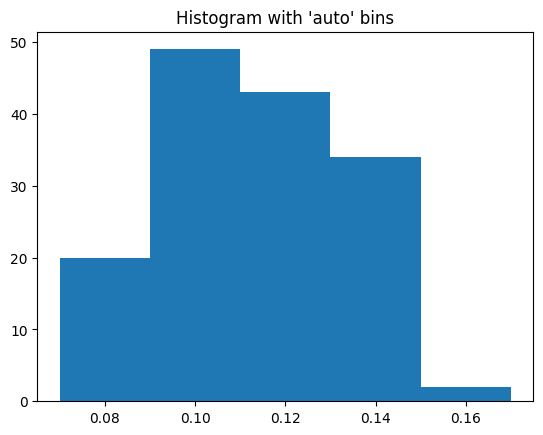

In [49]:
import matplotlib.pyplot as plt

plt.hist(Xcalclass['1.02'], bins=5)  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [50]:
def predicates_by_histogram(zone_sums_df, n_bins=4):
    """
    Generate predicates based on histogram bin edges for each column in a DataFrame.
    
    Parameters
    ----------
    - **zone_sums_df** : pd.DataFrame
        DataFrame with the aggregated values (sums) for spectral zones.
    - **n_bins** : int
        Number of histogram bins to generate predicates for.
    
    Returns
    -------
    - **predicates_df** : pd.DataFrame
        DataFrame containing the generated predicates.
    """
    import pandas as pd
    import numpy as np

    zone_predicate_list = [] # list to store predicates
    predicate_num = 1 # predicate counter
    for zone in zone_sums_df.columns: # loop over zones
        # calculating histogram bin edges
        _, bin_edges = np.histogram(zone_sums_df[zone], bins=n_bins) # getting bin edges
        bin_edges = bin_edges[1:-1] # removing the max and min edges as they are the max and min of the data (beyond which no data exists)

        for i in range(len(bin_edges) - 1): # loop over bin edges (excluding the last edge)
            edge = bin_edges[i] # current edge
            # <= edge
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} <= {edge:.2f}",
                'zone': zone,
                'thresholds': f"{edge:.2f}",
                'operator': "<="
            })
            predicate_num += 1
            # > edge
            zone_predicate_list.append({
                'predicate': f'P{predicate_num}',
                'rule': f"{zone} > {edge:.2f}",
                'zone': zone,
                'thresholds': f"{edge:.2f}",
                'operator': ">"
            })
            predicate_num += 1
    
    predicates_df = pd.DataFrame(zone_predicate_list)
    return predicates_df

In [51]:
predicates_df = predicates_by_histogram(zone_sums_df, n_bins=6) # getting predicates based on histogram with 6 bins (excluding min and max edges)
predicates_df

predicate         rule zone thresholds operator
0          P1  Al <= 26.61   Al      26.61       <=
1          P2   Al > 26.61   Al      26.61        >
2          P3  Al <= 28.77   Al      28.77       <=
3          P4   Al > 28.77   Al      28.77        >
4          P5  Al <= 30.93   Al      30.93       <=
..        ...          ...  ...        ...      ...
107      P108   Cu > 16.96   Cu      16.96        >
108      P109  Cu <= 17.86   Cu      17.86       <=
109      P110   Cu > 17.86   Cu      17.86        >
110      P111  Cu <= 18.75   Cu      18.75       <=
111      P112   Cu > 18.75   Cu      18.75        >

[112 rows x 5 columns]

In [83]:
# function to evaluate a predicate for a given value
def eval_predicate(value, thresholds, operator): # evaluates a predicate for a given value
    if operator == "<=": # less than or equal
        return float(value <= float(thresholds)) # returns 1.0 if true, 0.0 if false
    elif operator == ">": # greater than
        return float(value > float(thresholds)) # returns 1.0 if true, 0.0 if false
    else:
        return np.nan  # unknown operator

# generating the predicate indicator DataFrame
predicate_indicator_df = pd.DataFrame(index=zone_sums_df.index) # initializing empty DataFrame

for _, row in predicates_df.iterrows(): # iterating over each predicate (iterrows returns index and row)
    pred = row['predicate'] # getting predicate name
    zone = row['zone'] # getting zone name
    thresholds = row['thresholds'] # getting thresholds
    operator = row['operator'] # getting operator
    predicate_indicator_df[pred] = zone_sums_df[zone].apply(lambda v: eval_predicate(v, thresholds, operator)).astype(int)
predicate_indicator_df.columns = predicates_df['rule'].tolist() # setting column names    
predicate_indicator_df # displaying the predicate indicator DataFrame

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  Al <= 33.85  \
0              1           0            1           0            1   
1              0           1            1           0            1   
2              1           0            1           0            1   
3              1           0            1           0            1   
4              0           1            1           0            1   
..           ...         ...          ...         ...          ...   
143            0           1            1           0            1   
144            1           0            1           0            1   
145            0           1            1           0            1   
146            1           0            1           0            1   
147            0           1            0           1            0   

     Al > 33.85  Si <= 74.25  Si > 74.25  Si <= 78.45  Si > 78.45  ...  \
0             0            0           1            0           1  ...   
1             0            0           1            0           1  ...   
2             0            0           1            0           1  ...   
3             0            0           1            0           1  ...   
4             0            0           1            0           1  ...   
..          ...          ...         ...          ...         ...  ...   
143           0            0           1            1           0  ...   
144           0            0           1            1           0  ...   
145           0            0           1            1           0  ...   
146           0            1           0            1           0  ...   
147           1            0           1            0           1  ...   

     Fe kb <= 662.78  Fe kb > 662.78  Fe kb <= 675.61  Fe kb > 675.61  \
0                  1               0                1               0   
1                  1               0                1               0   
2                  1               0                1               0   
3                  0               1                1               0   
4                  1               0                1               0   
..               ...             ...              ...             ...   
143                0               1                0               1   
144                0               1                1               0   
145                0               1                1               0   
146                1               0                1               0   
147                0               1                0               1   

     Cu <= 17.01  Cu > 17.01  Cu <= 17.56  Cu > 17.56  Cu <= 18.06  Cu > 18.06  
0              0           1            1           0            1           0  
1              0           1            1           0            1           0  
2              0           1            1           0            1           0  
3              1           0            1           0            1           0  
4              0           1            1           0            1           0  
..           ...         ...          ...         ...          ...         ...  
143            0           1            1           0            1           0  
144            1           0            1           0            1           0  
145            1           0            1           0            1           0  
146            1           0            1           0            1           0  
147            0           1            0           1            0           1  

[148 rows x 84 columns]

In [84]:
# co-ocurrence matrix
co_occurrence_matrix = np.dot(predicate_indicator_df.T, predicate_indicator_df)
co_occurrence_matrix_df = pd.DataFrame(co_occurrence_matrix, index=predicate_indicator_df.columns, columns=predicate_indicator_df.columns)
co_occurrence_matrix_df
## the co-occurrence matrix indicates how many samples satisfy each pair of predicates
## for example, if P1 and P2 co-occur in 10 samples, the value at (P1, P2) and (P2, P1) will be 10
## the principal diagonal indicates how many samples satisfy each individual predicate
## while the off-diagonal elements indicate co-occurrence counts

Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  Al <= 33.85  \
Al <= 30.68           37           0           37           0           37   
Al > 30.68             0         111           37          74           73   
Al <= 32.19           37          37           74           0           74   
Al > 32.19             0          74            0          74           36   
Al <= 33.85           37          73           74          36          110   
...                  ...         ...          ...         ...          ...   
Cu > 17.01            19          91           46          64           78   
Cu <= 17.56           27          47           47          27           62   
Cu > 17.56            10          64           27          47           48   
Cu <= 18.06           34          77           66          45           90   
Cu > 18.06             3          34            8          29           20   

             Al > 33.85  Si <= 74.25  Si > 74.25  Si <= 78.45  Si > 78.45  \
Al <= 30.68           0           10          27           17          20   
Al > 30.68           38           27          84           57          54   
Al <= 32.19           0           21          53           36          38   
Al > 32.19           38           16          58           38          36   
Al <= 33.85           0           30          80           52          58   
...                 ...          ...         ...          ...         ...   
Cu > 17.01           32           23          87           53          57   
Cu <= 17.56          12           24          50           36          38   
Cu > 17.56           26           13          61           38          36   
Cu <= 18.06          21           34          77           60          51   
Cu > 18.06           17            3          34           14          23   

             ...  Fe kb <= 662.78  Fe kb > 662.78  Fe kb <= 675.61  \
Al <= 30.68  ...               28               9               35   
Al > 30.68   ...               46              65               76   
Al <= 32.19  ...               50              24               64   
Al > 32.19   ...               24              50               47   
Al <= 33.85  ...               63              47               89   
...          ...              ...             ...              ...   
Cu > 17.01   ...               53              57               81   
Cu <= 17.56  ...               42              32               55   
Cu > 17.56   ...               32              42               56   
Cu <= 18.06  ...               60              51               85   
Cu > 18.06   ...               14              23               26   

             Fe kb > 675.61  Cu <= 17.01  Cu > 17.01  Cu <= 17.56  Cu > 17.56  \
Al <= 30.68               2           18          19           27          10   
Al > 30.68               35           20          91           47          64   
Al <= 32.19              10           28          46           47          27   
Al > 32.19               27           10          64           27          47   
Al <= 33.85              21           32          78           62          48   
...                     ...          ...         ...          ...         ...   
Cu > 17.01               29            0         110           36          74   
Cu <= 17.56              19           38          36           74           0   
Cu > 17.56               18            0          74            0          74   
Cu <= 18.06              26           38          73           74          37   
Cu > 18.06               11            0          37            0          37   

             Cu <= 18.06  Cu > 18.06  
Al <= 30.68           34           3  
Al > 30.68            77          34  
Al <= 32.19           66           8  
Al > 32.19            45          29  
Al <= 33.85           90          20  
...                  ...         ...  
Cu > 17.01            73          37  
Cu <= 17.56           74 

In [85]:
# inserting the assigned class based on the model predictions to the predicate indicator DataFrame
predicate_indicator_df.insert(0, 'Class_predicted', plsda_results[1].iloc[:, -1]) # inserting the predicted class from plsda_results
predicate_indicator_df

Class_predicted  Al <= 30.68  Al > 30.68  Al <= 32.19  Al > 32.19  \
0               eut            1           0            1           0   
1               eut            0           1            1           0   
2               eut            1           0            1           0   
3               eut            1           0            1           0   
4               eut            0           1            1           0   
..              ...          ...         ...          ...         ...   
143             eut            0           1            1           0   
144            dist            1           0            1           0   
145            dist            0           1            1           0   
146            dist            1           0            1           0   
147            dist            0           1            0           1   

     Al <= 33.85  Al > 33.85  Si <= 74.25  Si > 74.25  Si <= 78.45  ...  \
0              1           0            0           1            0  ...   
1              1           0            0           1            0  ...   
2              1           0            0           1            0  ...   
3              1           0            0           1            0  ...   
4              1           0            0           1            0  ...   
..           ...         ...          ...         ...          ...  ...   
143            1           0            0           1            1  ...   
144            1           0            0           1            1  ...   
145            1           0            0           1            1  ...   
146            1           0            1           0            1  ...   
147            0           1            0           1            0  ...   

     Fe kb <= 662.78  Fe kb > 662.78  Fe kb <= 675.61  Fe kb > 675.61  \
0                  1               0                1               0   
1                  1               0                1               0   
2                  1               0                1               0   
3                  0               1                1               0   
4                  1               0                1               0   
..               ...             ...              ...             ...   
143                0               1                0               1   
144                0               1                1               0   
145                0               1                1               0   
146                1               0                1               0   
147                0               1                0               1   

     Cu <= 17.01  Cu > 17.01  Cu <= 17.56  Cu > 17.56  Cu <= 18.06  Cu > 18.06  
0              0           1            1           0            1           0  
1              0           1            1           0            1           0  
2              0           1            1           0            1           0  
3              1           0            1           0            1           0  
4              0           1            1           0            1           0  
..           ...         ...          ...         ...          ...         ...  
143            0           1            1           0            1           0  
144            1           0            1           0            1           0  
145            1           0            1           0            1           0  
146            1           0            1           0            1           0  
147            0           1            0           1            0           1  

[148 rows x 85 columns]

In [86]:
predicate_info_dict = {}
for _, row in predicates_df.iterrows(): # o iterrows retorna o indice e a linha do dataframe (a linha contem os dados que podem ser acessados por nome de coluna)
    pred = row['rule'] # capturando o nome do predicado (regra)
    # selecionando as amostras que satisfazem o predicado (valor 1 na coluna do predicado)
    satisfied_samples = zone_sums_df.index[predicate_indicator_df[pred] == 1].tolist() # o == 1 indica que a amostra satisfaz o predicado (valor 1 na coluna do predicado)
    if satisfied_samples: # apenas se houver amostras que satisfazem o predicado
        # criando o dataframe com as informacoes
        df_info = pd.DataFrame({
            'Zone_Sum': zone_sums_df.loc[satisfied_samples, row['zone']].reset_index(drop=True), # a zona correspondente ao predicado 
            # a lista satisfied_samples foi gerada contendo os indices das amostras que satisfazem o predicado
            'Predicted_Y': plsda_results[5].iloc[satisfied_samples, -1].reset_index(drop=True) # os valores preditos pelo modelo para essas amostras
        })
        predicate_info_dict[pred] = df_info

In [88]:
predicate_info_dict['Al <= 30.68'] # exhibiting the information DataFrame for the predicate

Zone_Sum  Predicted_Y
0     26.450     0.007734
1     28.245     0.304601
2     29.555     0.298230
3     28.615    -0.030014
4     27.535    -0.131567
5     28.020     0.412764
6     30.405     0.489468
7     27.685    -0.238389
8     28.230     0.173240
9     26.255     0.087942
10    29.390     0.442836
11    26.575     0.108477
12    29.405    -0.029605
13    27.650    -0.223870
14    30.340     0.203201
15    25.240    -0.301298
16    29.670    -0.132671
17    29.550     0.223288
18    28.280    -0.108126
19    26.960     0.214063
20    29.890     0.280978
21    28.900     0.247935
22    28.820     0.006784
23    25.680    -0.276551
24    29.250    -0.182890
25    24.455     0.366802
26    30.220     0.315884
27    30.390     0.630977
28    30.635     0.486295
29    30.055     0.335653
30    30.220     0.804029
31    28.955     0.521954
32    26.715     0.411149
33    29.590     0.643224
34    27.375     0.356871
35    30.330     0.893304
36    27.650     0.673792

# **Bagging**

In [89]:
def bagging_predicates(predicate_info_dict, n_bags, n_predicates_per_bag, n_samples_per_bag, n_total_samples, replace=False, random_seed=42):
    """
    Realiza o bagging de predicados selecionando aleatoriamente predicados e amostras compartilhadas.
    
    Parâmetros
    ----------
    - **predicate_info_dict** : dict
        Dicionário com nomes de predicados como chaves e DataFrames com somas de zonas e Y predito como valores.
    - **n_bags** : int
        Número de bags a serem criados.
    - **n_predicates_per_bag** : int
        Número de predicados a serem selecionados para cada bag.
    - **n_samples_per_bag** : int
        Número de amostras compartilhadas a serem selecionadas para cada bag.
    - **n_total_samples** : int
        Número total de amostras no dataset de calibração (ex: 148).
    - **replace** : bool, opcional
        Estratégia de amostragem:
        - **False**: Sem reposição (cada amostra aparece no máximo 1 vez no bag)
                     Se n_samples_per_bag > n_total_samples, usa n_total_samples
        - **True**: Com reposição (bootstrap - amostras podem repetir)
                    Permite n_samples_per_bag > n_total_samples
        Padrão é False.
    - **random_seed** : int, opcional
        Semente aleatória para reprodutibilidade. Padrão é 42.
    
    Returns
    -------
    - **bags_dict** : dict
        Dicionário com nomes dos bags como chaves e dicionários de predicados selecionados como valores.
    """
    import numpy as np
    import pandas as pd

    np.random.seed(random_seed) # definindo a semente aleatória para reprodutibilidade
    predicate_names = list(predicate_info_dict.keys()) # lista de nomes dos predicados
    bags_dict = {} # dicionário para armazenar os bags

    # CRIANDO OS BAGS
    for bag_num in range(1, n_bags + 1): # loop sobre o número de bags
        
        # Selecionar predicados para este bag (ALEATÓRIO)
        selected_predicates = np.random.choice(
            predicate_names, # lista de nomes dos predicados 
            size=n_predicates_per_bag, # número de predicados a serem selecionados
            replace=False # sem reposição
        )
        
        # Selecionar amostras COMPARTILHADAS diretamente do conjunto completo
        # Ajustar n_samples_per_bag se exceder o total de amostras disponíveis
        n_samples_to_use = min(n_samples_per_bag, n_total_samples) if not replace else n_samples_per_bag
        
        # Amostragem das amostras do conjunto completo (com ou sem reposição)
        bag_sample_indices = np.random.choice(
            range(n_total_samples),  # [0, 1, 2, ..., n_total_samples-1]
            size=n_samples_to_use, # número de amostras a serem selecionadas
            replace=replace # com ou sem reposição
        )
                
        # Para cada predicado, filtrar apenas as amostras deste bag
        bag_predicate_dict = {} # dicionário para armazenar os predicados selecionados para o bag
        
        for pred in selected_predicates: # loop sobre os predicados selecionados
            df_pred_full = predicate_info_dict[pred] # obtendo o dataframe do predicado
            
            if not df_pred_full.empty: # apenas se o dataframe não estiver vazio
                # Filtra apenas as linhas cujos índices estão em bag_sample_indices
                valid_indices = [idx for idx in bag_sample_indices if idx in df_pred_full.index] # índices válidos para este bag (interseção entre bag_sample_indices e df_pred_full.index)
                
                if len(valid_indices) > 0: # apenas se houver amostras válidas para este bag
                    df_selected = df_pred_full.loc[valid_indices] # selecionando as amostras válidas
                    df_selected = df_selected.reset_index(drop=True) # resetando o índice do dataframe selecionado
                    bag_predicate_dict[pred] = df_selected # armazenando o dataframe selecionado no dicionário do bag
                else:
                    print(f"Predicado '{pred[:40]}...' não tem amostras válidas no bag {bag_num}.")
        
        bags_dict[f'Bag_{bag_num}'] = bag_predicate_dict

    return bags_dict

In [ ]:
predicate_info_dict['Ca ka > 29.58'] # exibindo o DataFrame de informações para o predicado

Zone_Sum  Predicted_Y
0     34.065     0.007734
1     36.785     0.110601
2     30.950     0.298230
3     31.425    -0.030014
4     41.650     0.216963
5     45.880     0.067665
6     39.225    -0.131567
7     48.435    -0.088671
8     33.050     0.467527
9     36.080     0.158347
10    38.365    -0.238389
11    41.230     0.307759
12    34.750     0.173240
13    36.200     0.087942
14    38.030     0.108477
15    52.955    -0.029605
16    44.995     0.242099
17    38.240    -0.223870
18    36.930     0.264794
19    32.490     0.140971
20    42.280     0.203201
21    46.850    -0.301298
22    31.890    -0.132671
23    48.540    -0.108126
24    41.210     0.237469
25    44.590     0.243870
26    38.310     0.305537
27    40.905     0.006784
28    42.430    -0.276551
29    30.900     0.395246
30    30.020     0.471691
31    29.790     0.172105
32    54.090    -0.182890
33    38.080     0.368135
34    30.990     0.315884
35   120.240    -1.236192
36    30.660     0.502668

In [92]:
bags_result = bagging_predicates(
    predicate_info_dict, # dicionário de predicados com informações (somas de zonas e Y predito)
    n_bags=100, # número de bags a serem criados
    n_predicates_per_bag=25, # número de predicados a serem selecionados para cada bag
    n_total_samples=len(Xcalclass), # número total de amostras no dataset de calibração
    n_samples_per_bag=80,  # número de amostras compartilhadas a serem selecionadas para cada bag
    replace=False, # amostragem com reposição (bootstrap)
    random_seed=1 # semente aleatória para reprodutibilidade
    )

In [59]:
bags_result['Bag_1'].keys()

dict_keys([np.str_('Fe ka > 3969.26'), np.str_('K <= 16.04'), np.str_('Ca kb <= 13.63'), np.str_('Mn <= 43.94'), np.str_('Ti ka > 434.97'), np.str_('Fe kb > 676.50'), np.str_('Fe kb > 622.98'), np.str_('Ca kb <= 16.30'), np.str_('Rh L + Ar > 145.68'), np.str_('Rh L + Ar <= 152.04'), np.str_('Ti ka > 353.37'), np.str_('Fe ka <= 4151.10'), np.str_('Al <= 28.77'), np.str_('Fe kb <= 649.74'), np.str_('Cu > 16.07'), np.str_('Ca ka > 66.67'), np.str_('Fe kb <= 622.98'), np.str_('Fe ka > 4332.93'), np.str_('Fe ka <= 3969.26'), np.str_('K <= 14.59'), np.str_('Ti kb <= 91.87'), np.str_('P > 3.04'), np.str_('Ti kb <= 104.51'), np.str_('Ca ka <= 84.53'), np.str_('Fe ka > 3787.42')])

In [60]:
def bagging_predicates_v2(zone_sums_df, y_predicted_numeric, predicates_df, 
                          n_bags=50, n_predicates_per_bag=20, n_samples_per_bag=80, 
                          min_samples_per_predicate=5, replace=True, random_seed=42):
    """
    Realiza bagging de predicados com maior consistência na amostragem
    
    Estratégia:
    - Amostra N amostras PRIMEIRO (define o "universo" do bag)
    - Seleciona M predicados aleatoriamente
    - Para cada predicado: filtra usando APENAS as N amostras do bag
    - Descarta predicados com < min_samples_per_predicate amostras satisfeitas
    
    Parâmetros
    ----------
    - **zone_sums_df** : pd.DataFrame
        DataFrame com somas das zonas espectrais (linhas=amostras, colunas=zonas)
    - **y_predicted_numeric** : pd.Series ou np.ndarray
        Valores preditos pelo modelo PLSDA (contínuos, entre 0 e 1)
    - **predicates_df** : pd.DataFrame
        DataFrame com predicados (colunas: 'rule', 'zone', 'thresholds', 'operator')
    - **n_bags** : int
        Número de bags a criar
    - **n_predicates_per_bag** : int
        Número de predicados candidatos por bag
    - **n_samples_per_bag** : int
        Número de amostras a amostrar por bag
    - **min_samples_per_predicate** : int
        Mínimo de amostras que um predicado deve ter no bag para ser mantido
    - **replace** : bool
        True = bootstrap (com reposição), False = sem reposição
    - **random_seed** : int
        Semente aleatória para reprodutibilidade
    
    Returns
    -------
    - **bags_dict** : dict
        Dicionário {bag_name: {predicate_rule: DataFrame}}
        Cada DataFrame tem colunas: ['Zone_Sum', 'Predicted_Y', 'Sample_Index']
    """
    import numpy as np
    import pandas as pd
    
    np.random.seed(random_seed)  # fixando semente para reprodutibilidade
    
    n_total_samples = len(zone_sums_df)  # total de amostras no dataset completo
    predicate_rules = predicates_df['rule'].tolist()  # lista de todas as regras de predicados
    bags_dict = {}  # dicionário para armazenar os bags
    
    # LOOP PRINCIPAL: CRIANDO CADA BAG
    for bag_num in range(1, n_bags + 1):
        
        # AMOSTRAGEM PRIMÁRIA - SELECIONAR N AMOSTRAS PARA ESTE BAG
        # Estas amostras serão COMPARTILHADAS por TODOS os predicados deste bag
        bag_sample_indices = np.random.choice(
            range(n_total_samples),  # pool de índices [0, 1, 2, ..., n_total_samples-1]
            size=n_samples_per_bag,  # quantas amostras amostrar
            replace=replace  # True = bootstrap, False = sem reposição
        )
        
        # SELEÇÃO DE PREDICADOS CANDIDATOS
        # Seleciona M predicados aleatoriamente (sem reposição entre predicados)
        selected_predicate_rules = np.random.choice(
            predicate_rules,  # lista de todas as regras
            size=min(n_predicates_per_bag, len(predicate_rules)),  # não exceder total disponível
            replace=False  # cada predicado aparece no máximo 1 vez
        )
        
        # FILTRAGEM E VALIDAÇÃO DE PREDICADOS
        bag_predicate_dict = {}  # dicionário para armazenar predicados válidos deste bag
        n_discarded = 0  # contador de predicados descartados
        
        for pred_rule in selected_predicate_rules:  # itera sobre cada predicado candidato
            
            # Recuperando metadados do predicado (zona, threshold, operador)
            pred_row = predicates_df[predicates_df['rule'] == pred_rule].iloc[0]  # primeira (única) linha correspondente
            zone = pred_row['zone']  # nome da zona espectral (ex: 'Ca ka')
            threshold = float(pred_row['thresholds'])  # valor do threshold
            operator = pred_row['operator']  # "<=" ou ">"
            
            # Extrai os valores da zona APENAS para as amostras do bag
            zone_values_bag = zone_sums_df.loc[bag_sample_indices, zone].values  # valores da zona para as N amostras
            
            # Aplica o predicado: quais amostras satisfazem a regra?
            if operator == "<=":
                mask_satisfied = zone_values_bag <= threshold  # máscara booleana
            elif operator == ">":
                mask_satisfied = zone_values_bag > threshold
            else:
                continue  # pula este predicado
            
            # Filtra APENAS as amostras que satisfazem o predicado
            satisfied_indices_in_bag = bag_sample_indices[mask_satisfied]  # índices originais das amostras satisfeitas
            
            # VALIDAÇÃO: Verifica se há amostras suficientes
            if len(satisfied_indices_in_bag) < min_samples_per_predicate: # o if checa se o número de amostras satisfeitas é menor que o mínimo exigido. Se for, o predicado é descartado atraves do continue
                n_discarded += 1  # incrementa contador de descartados
                continue  # o continue faz com que o loop pule para a próxima iteração, descartando o predicado atual
            
            # Só chega aqui se o predicado for válido (tem amostras suficientes)
            # Criar DataFrame com informações relevantes
            df_predicate_info = pd.DataFrame({
                'Zone_Sum': zone_sums_df.loc[satisfied_indices_in_bag, zone].values,  # valores da zona
                'Predicted_Y': y_predicted_numeric.iloc[satisfied_indices_in_bag].values,  # valores preditos
                'Sample_Index': satisfied_indices_in_bag  # índices originais (para rastreabilidade)
            })
            
            # Armazena no dicionário do bag
            bag_predicate_dict[pred_rule] = df_predicate_info
        
        # ARMAZENAMENTO DO BAG (se não estiver vazio)
        if len(bag_predicate_dict) > 0:  # apenas se houver predicados válidos
            bags_dict[f'Bag_{bag_num}'] = bag_predicate_dict
            print(f"Bag_{bag_num}: {len(bag_predicate_dict)} predicados válidos ({n_discarded} descartados)")
        else:
            print(f"X Bag_{bag_num}: VAZIO (todos os {n_predicates_per_bag} predicados descartados)")
        
    return bags_dict

In [101]:
y_predicted_numeric = plsda_results[5].iloc[:, -1]  # última coluna com predições numéricas

bags_result= bagging_predicates_v2(
    zone_sums_df=zone_sums_df,  # zonas espectrais
    y_predicted_numeric=y_predicted_numeric,  # predições do modelo
    predicates_df=predicates_df,  # predicados disponíveis
    n_bags=60,  # número de bags
    n_predicates_per_bag=40,  # predicados candidatos por bag
    n_samples_per_bag=100,  # amostras por bag (80% do dataset, por exemplo)
    min_samples_per_predicate=30,  # mínimo para manter predicado
    replace=False,  # bootstrap (com reposição)
    random_seed=1  # reprodutibilidade
)

Bag_1: 26 predicados válidos (14 descartados)
Bag_2: 28 predicados válidos (12 descartados)
Bag_3: 24 predicados válidos (16 descartados)
Bag_4: 31 predicados válidos (9 descartados)
Bag_5: 24 predicados válidos (16 descartados)
Bag_6: 28 predicados válidos (12 descartados)
Bag_7: 29 predicados válidos (11 descartados)
Bag_8: 30 predicados válidos (10 descartados)
Bag_9: 26 predicados válidos (14 descartados)
Bag_10: 28 predicados válidos (12 descartados)
Bag_11: 27 predicados válidos (13 descartados)
Bag_12: 28 predicados válidos (12 descartados)
Bag_13: 28 predicados válidos (12 descartados)
Bag_14: 28 predicados válidos (12 descartados)
Bag_15: 24 predicados válidos (16 descartados)
Bag_16: 28 predicados válidos (12 descartados)
Bag_17: 30 predicados válidos (10 descartados)
Bag_18: 26 predicados válidos (14 descartados)
Bag_19: 32 predicados válidos (8 descartados)
Bag_20: 25 predicados válidos (15 descartados)
Bag_21: 27 predicados válidos (13 descartados)
Bag_22: 28 predicados vá

In [103]:
bags_result['Bag_1']['Al <= 33.85']

Zone_Sum  Predicted_Y  Sample_Index
0     33.330     0.778640           121
1     33.570     0.493602           104
2     33.025     0.605969            99
3     32.690     0.415932            75
4     33.090     0.640598            90
..       ...          ...           ...
68    32.840     0.739291           131
69    30.055     0.335653            87
70    31.360     0.698275           138
71    26.715     0.411149           107
72    28.020     0.412764            15

[73 rows x 3 columns]

In [104]:
# inserindo a classe prevista em cada DataFrame de informações dos predicados em cada bag
for bag_name, pred_dict in bags_result.items(): # iterando sobre cada bag
    for pred_rule, df_info in pred_dict.items(): # iterando sobre cada predicado no bag
        # atribuindo a classe prevista com base no valor predito
        df_info['Class_Predicted'] = np.where(df_info['Predicted_Y'] >= 0.5, 'eut', 'dist') # binarizando com threshold 0.5, onde >=0.5 é 'eut' e <0.5 é 'dist'

In [105]:
# calculando a informacao mutual entre as zonas espectrais e as predicoes do modelo em cada bag
# e salvar em um df frame ordenando do maior para o menor valor de informacao mutual
from sklearn.feature_selection import mutual_info_regression
mi_results_dict = {}
for bag_name, predicates_dict in bags_result.items(): # iterando sobre cada bag
    mi_results = {}
    for pred_rule, df_info in predicates_dict.items(): # iterando sobre cada predicado no bag
        X_zone = df_info['Zone_Sum'].values.reshape(-1, 1)  # valores da zona (reshape para 2D)
        y_pred = df_info['Predicted_Y'].values  # valores preditos
        mi_score = mutual_info_regression(X_zone, y_pred, discrete_features=False)
        mi_results[pred_rule] = mi_score[0]  # armazenando o score de MI
    # convertendo para DataFrame e ordenando
    mi_results_df = pd.DataFrame.from_dict(mi_results, orient='index', columns=['Mutual_Info'])
    mi_results_df = mi_results_df.sort_values(by='Mutual_Info', ascending=False)
    mi_results_df.insert(0, 'Predicate', mi_results_df.index)  # adicionando coluna de predicado
    mi_results_df = mi_results_df.reset_index(drop=True)  # resetando o índice
    mi_results_dict[bag_name] = mi_results_df  # armazenando o DataFrame


In [106]:
mi_results_dict['Bag_1']

Predicate  Mutual_Info
0         Ca ka > 17.84     0.334970
1        Ca ka <= 22.10     0.299999
2       Ti ka <= 431.16     0.284786
3            Si > 74.25     0.251407
4              S > 6.53     0.216648
5            Al > 30.68     0.205731
6       Ti kb <= 104.15     0.195633
7         Ca ka > 22.10     0.180067
8           Al <= 33.85     0.172926
9         Ti kb > 99.29     0.143572
10          Mn <= 42.63     0.133430
11      Ti ka <= 458.73     0.123625
12     Fe ka <= 4340.48     0.103745
13      Fe ka > 4121.11     0.103203
14            K > 13.77     0.051085
15       Ti ka > 431.16     0.043131
16            S <= 6.78     0.042783
17           K <= 15.82     0.041996
18           K <= 14.64     0.041338
19            S <= 7.04     0.022518
20     Fe ka <= 4251.20     0.020814
21      Fe kb <= 662.78     0.000000
22       Fe kb > 662.78     0.000000
23      Fe ka > 4251.20     0.000000
24  Rh L + Ar <= 150.55     0.000000
25          Si <= 78.45     0.000000

In [107]:
# vamos remover de mi_results_dict os predicados que possuem MI = 0
for bag_name, mi_df in mi_results_dict.items(): # iterating over each bag
    mi_results_dict[bag_name] = mi_df[mi_df['Mutual_Info'] > 0].reset_index(drop=True) # filtering out MI = 0 and resetting index
mi_results_dict['Bag_1'] # exhibiting the MI results for Bag 2 

Predicate  Mutual_Info
0      Ca ka > 17.84     0.334970
1     Ca ka <= 22.10     0.299999
2    Ti ka <= 431.16     0.284786
3         Si > 74.25     0.251407
4           S > 6.53     0.216648
5         Al > 30.68     0.205731
6    Ti kb <= 104.15     0.195633
7      Ca ka > 22.10     0.180067
8        Al <= 33.85     0.172926
9      Ti kb > 99.29     0.143572
10       Mn <= 42.63     0.133430
11   Ti ka <= 458.73     0.123625
12  Fe ka <= 4340.48     0.103745
13   Fe ka > 4121.11     0.103203
14         K > 13.77     0.051085
15    Ti ka > 431.16     0.043131
16         S <= 6.78     0.042783
17        K <= 15.82     0.041996
18        K <= 14.64     0.041338
19         S <= 7.04     0.022518
20  Fe ka <= 4251.20     0.020814

In [108]:
# listing the top predicate by MI for each bag
for bag_name, mi_df in mi_results_dict.items():
    top_mi = mi_df.iloc[0] if not mi_df.empty else None
    print(f"{bag_name}: {top_mi}")

Bag_1: Predicate      Ca ka > 17.84
Mutual_Info          0.33497
Name: 0, dtype: object
Bag_2: Predicate      Ca kb > 12.91
Mutual_Info         0.431075
Name: 0, dtype: object
Bag_3: Predicate      Ca ka > 17.84
Mutual_Info         0.394891
Name: 0, dtype: object
Bag_4: Predicate      Si > 74.25
Mutual_Info      0.321309
Name: 0, dtype: object
Bag_5: Predicate      Ca kb > 12.25
Mutual_Info         0.339897
Name: 0, dtype: object
Bag_6: Predicate      Ca ka > 17.84
Mutual_Info         0.381168
Name: 0, dtype: object
Bag_7: Predicate      Ca kb > 12.25
Mutual_Info         0.500923
Name: 0, dtype: object
Bag_8: Predicate      Ca ka > 17.84
Mutual_Info         0.380272
Name: 0, dtype: object
Bag_9: Predicate      Al > 32.19
Mutual_Info      0.337464
Name: 0, dtype: object
Bag_10: Predicate      Ca ka > 17.84
Mutual_Info         0.448093
Name: 0, dtype: object
Bag_11: Predicate      Ca ka <= 29.58
Mutual_Info          0.397457
Name: 0, dtype: object
Bag_12: Predicate      Si > 74.25
Mutual

# **Building the graph**

**Metáfora**: Cada bag é um "guia turístico" que sugere uma rota. O grafo final é um mapa com todas as rotas sugeridas, e as amostras reais testam quais rotas funcionam melhor se acumulando nelas.

Acumulação concluída: 923 arestas criadas


Encontradas 177 arestas bidirecionais


Top 10 arestas bidirecionais (ranking por peso total):
----------------------------------------------------------------------

Ca ka > 17.84
  |
Ca kb > 12.25
  Peso A→B: 1020
  Peso B→A: 408
  VENCEDOR: A→B (vantagem: 612)

Ca ka > 22.10
  |
Ca kb > 12.25
  Peso A→B: 222
  Peso B→A: 518
  VENCEDOR: B→A (vantagem: 296)

Ca kb > 12.91
  |
Ca kb > 12.25
  Peso A→B: 146
  Peso B→A: 511
  VENCEDOR: B→A (vantagem: 365)

Ca kb > 12.25
  |
Ca ka <= 29.58
  Peso A→B: 511
  Peso B→A: 146
  VENCEDOR: A→B (vantagem: 365)

Ca ka > 22.10
  |
Ca kb > 12.91
  Peso A→B: 195
  Peso B→A: 455
  VENCEDOR: B→A (vantagem: 260)

K > 13.77
  |
Ti kb > 94.00
  Peso A→B: 445
  Peso B→A: 89
  VENCEDOR: A→B (vantagem: 356)

Mn <= 42.63
  |
Mn <= 47.69
  Peso A→B: 225
  Peso B→A: 300
  VENCEDOR: B→A (vantagem: 75)

Ca kb > 12.91
  |
Mn > 40.38
  Peso A→B: 186
  Peso B→A: 186
  VENCEDOR: B→A (vantagem: 0)

Ca ka > 17.84
  |
Ca ka <=

C:\Users\Usuario\AppData\Local\Temp\ipykernel_11576\1036733836.py:204: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



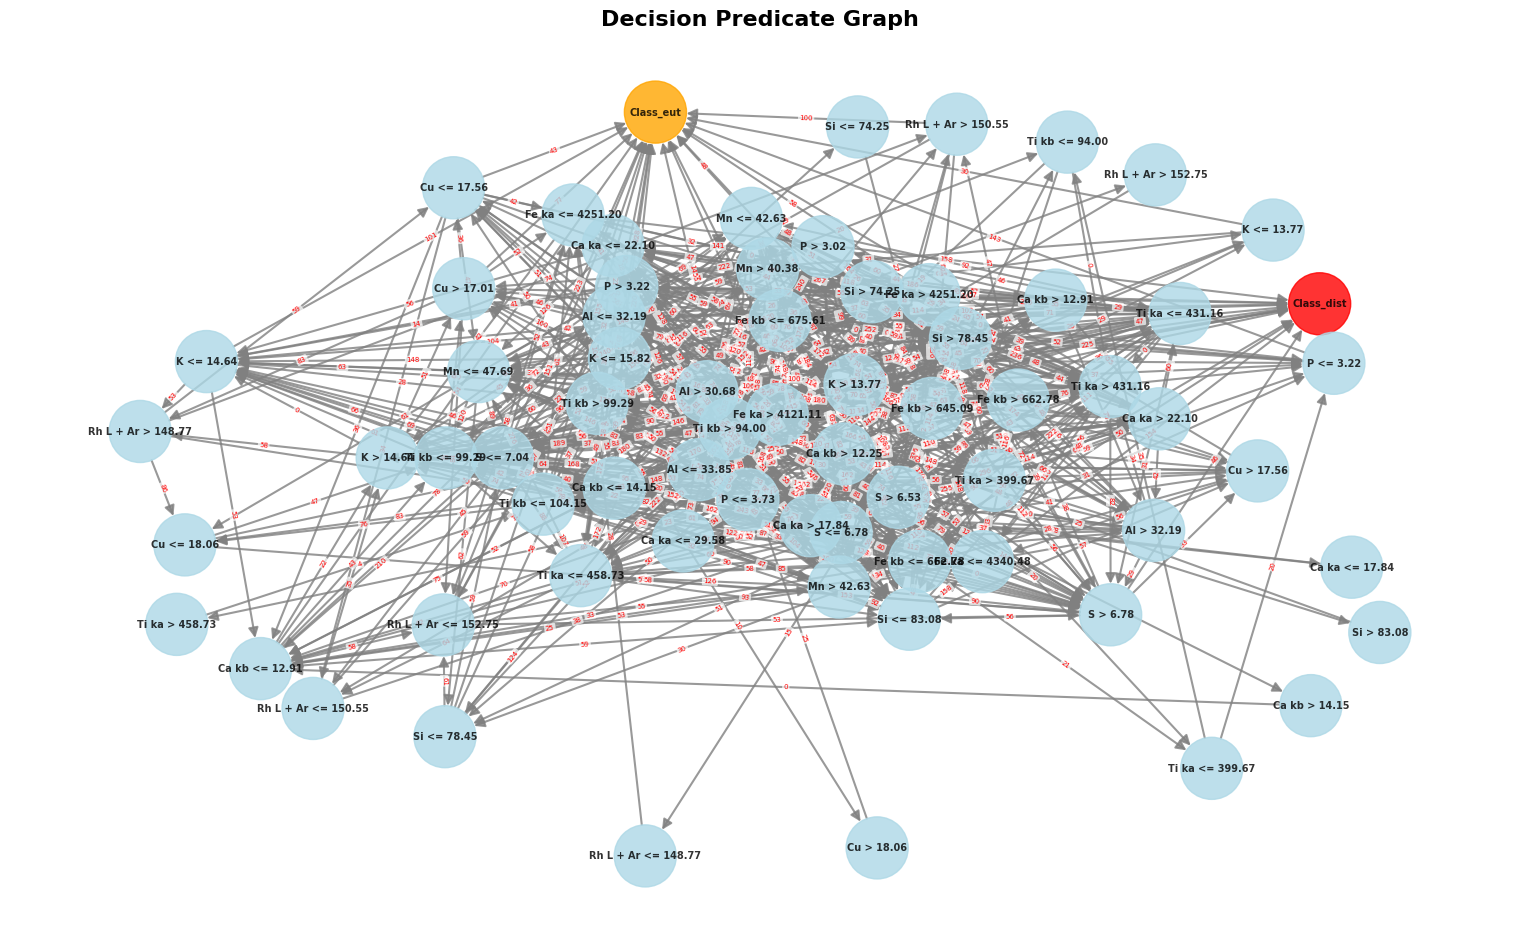

In [117]:
# Vamos usar os resultados de cada bag em bags_result para gerar varios caminhos em um grafo com o networkX
# A lista de predicados (chaves) de cada bag será usada para gerar os caminhos do grafo, que será direcionado pela ordem dos predicados cuja informação mútua (MI) é maior
# A MI esta disponível em mi_results_dict, vamos usar ela para ordenar os predicados de cada bag
# Já as arestas do grafo serao ponderadas pela frequencia com que uma amostra satisfaz dois predicados em sequencia (co-ocorrencia)
# Para o grafo ser direiconado precisamos eliminar as arestas bidirecionais
# Elas surgem quando dois predicados A e B aparecem em ordens diferentes em bags diferentes (A->B em um bag e B->A em outro bag)
# Estratégia: Acumular TODAS as arestas primeiro (em ambas as direções), depois decidir qual cortar baseada no peso
import networkx as nx

DG = nx.DiGraph()

# Adicionando nós terminais para cada classe
DG.add_node('Class_eut', node_type='terminal', class_label='eut')
DG.add_node('Class_dist', node_type='terminal', class_label='dist')

# Primeira parte - ACUMULAÇÃO (permitir as arestas bidirecionais temporariamente)
for bag_name, bag_predicates_dict in bags_result.items():
    
    # Obtendo o ranking de MI para este bag
    mi_ranking = mi_results_dict[bag_name] # DataFrame com ranking de MI
    ordered_predicates = mi_ranking['Predicate'].tolist() # lista de predicados ordenados por MI
    
    # Filtrando apenas predicados que existem neste bag
    ordered_predicates = [p for p in ordered_predicates if p in bag_predicates_dict.keys()]
    
    if len(ordered_predicates) == 0:
        continue
    
    # Construindo o caminho no grafo para este bag
    for i in range(len(ordered_predicates) - 1): # iterando sobre os predicados do bag, exceto o último
        pred_current = ordered_predicates[i] # predicado atual
        pred_next = ordered_predicates[i + 1] # próximo predicado (o + 1 faz o ultimo ser incluído)
        
        # Adicionando nós
        DG.add_node(pred_current, node_type='predicate')
        DG.add_node(pred_next, node_type='predicate')
        
        # Peso da aresta = co-ocorrência
        co_occurrence = co_occurrence_matrix_df.loc[pred_current, pred_next]
        
        # Aacumulação simples que incrementa o peso da aresta se ela já existe ou cria se ela não existe
        if DG.has_edge(pred_current, pred_next):
            DG[pred_current][pred_next]['weight'] += co_occurrence 
        else:
            DG.add_edge(pred_current, pred_next, weight=co_occurrence, bag=bag_name)
    
    # Conectando último predicado ao terminal
    last_pred = ordered_predicates[-1] # último predicado do bag
    DG.add_node(last_pred, node_type='predicate') # o add_node aqui é para garantir que o nó do último predicado exista
    # esse passo pode ser redundante, mas garante que o nó esteja presente no grafo antes de criar a aresta para o terminal
    # Por ex casos de bags com um único predicado nao gerariam o nó do último predicado no loop anterior
    
    df_last = bag_predicates_dict[last_pred]
    class_counts = df_last['Class_Predicted'].value_counts() # o value_counts conta quantas vezes cada classe aparece na coluna 'Class_Label'
    majority_class = class_counts.idxmax() # determinando a classe majoritária
    terminal_node = f'Class_{majority_class}'
    n_samples_last = class_counts.sum() # número total de amostras que satisfazem o último predicado
    
    if DG.has_edge(last_pred, terminal_node): # verificando se a aresta já existe
        DG[last_pred][terminal_node]['weight'] += n_samples_last # incrementa o peso
    else:
        DG.add_edge(last_pred, terminal_node, weight=n_samples_last, bag=bag_name) # cria a aresta

print(f"Acumulação concluída: {DG.number_of_edges()} arestas criadas\n")
print("="*70 + "\n")

# Identificação e corte das arestas bidirecionais - encontrar todos os pares bidirecionais
bidirectional_pairs = []
processed = set() # o set é usado para rastrear quais pares já foram processados (ele armazena as arestas já avaliadas)

for u, v in DG.edges():
    if DG.has_edge(v, u) and (v, u) not in processed: # verifica se a aresta reversa existe e não foi processada ainda
        weight_forward = DG[u][v]['weight']
        weight_reverse = DG[v][u]['weight']
        
        bidirectional_pairs.append({
            'node_A': u,
            'node_B': v,
            'weight_A_to_B': weight_forward,
            'weight_B_to_A': weight_reverse,
            'total_weight': weight_forward + weight_reverse,
            'winner_direction': 'A→B' if weight_forward > weight_reverse else 'B→A',
            'winner_weight': max(weight_forward, weight_reverse),
            'loser_weight': min(weight_forward, weight_reverse),
            'advantage': abs(weight_forward - weight_reverse)
        })
        
        processed.add((u, v)) # atualiza o set de processados
        processed.add((v, u)) # adiciona no set a aresta reversa também

print(f"Encontradas {len(bidirectional_pairs)} arestas bidirecionais\n")

# Mostrar top 10 pares bidirecionais
if len(bidirectional_pairs) > 0:
    df_bidirectional = pd.DataFrame(bidirectional_pairs)
    df_bidirectional = df_bidirectional.sort_values('total_weight', ascending=False)
    
    print("\nTop 10 arestas bidirecionais (ranking por peso total):")
    print("-" * 70)
    for idx, row in df_bidirectional.head(10).iterrows():
        print(f"\n{row['node_A'][:50]}")
        print(f"  |")
        print(f"{row['node_B'][:50]}")
        print(f"  Peso A→B: {row['weight_A_to_B']:.0f}")
        print(f"  Peso B→A: {row['weight_B_to_A']:.0f}")
        print(f"  VENCEDOR: {row['winner_direction']} (vantagem: {row['advantage']:.0f})")
    
    # Salvar relatório completo
    #df_bidirectional.to_csv('bidirectional_edges_report.csv', index=False)

# Removendo as arestas perdedoras (aqueles com menor peso)
print("="*70)

n_removed = 0
for pair in bidirectional_pairs:
    u = pair['node_A']
    v = pair['node_B']
    weight_forward = pair['weight_A_to_B']
    weight_reverse = pair['weight_B_to_A']
    
    if weight_forward > weight_reverse:
        DG.remove_edge(v, u)
        print(f"Removido: {v[:40]}... → {u[:40]}... (peso={weight_reverse:.0f})")
        print(f"Mantido:  {u[:40]}... → {v[:40]}... (peso={weight_forward:.0f})\n")
        n_removed += 1
    elif weight_reverse > weight_forward:
        DG.remove_edge(u, v)
        print(f"Removido: {u[:40]}... → {v[:40]}... (peso={weight_forward:.0f})")
        print(f"Mantido:  {v[:40]}... → {u[:40]}... (peso={weight_reverse:.0f})\n")
        n_removed += 1
    else:
        # Empate: critério de desempate - escolha aleatória
        if np.random.rand() > 0.5: # se o número aleatório for maior que 0.5
            DG.remove_edge(v, u)
            print(f"Removido por escolha aleatoria (empate): {v[:40]}... → {u[:40]}... (peso={weight_reverse:.0f})")
            print(f"Mantido: {u[:40]}... → {v[:40]}... (peso={weight_forward:.0f})\n")
            n_removed += 1
        else: # se <= 0.5
            DG.remove_edge(u, v)
            print(f"Removido por escolha aleatoria (empate): {u[:40]}... → {v[:40]}... (peso={weight_forward:.0f})")
            print(f"Mantido: {v[:40]}... → {u[:40]}... (peso={weight_reverse:.0f})\n")
            n_removed += 1
print("="*70 + "\n")

print(f"\n{n_removed} arestas removidas")

# Resumo do grafo final
print("\n" + "="*70)
print("Resumo do Grafo Final (após remoção de bidirecionais)")
print(f"Total de nós: {DG.number_of_nodes()}")
print(f"Total de arestas: {DG.number_of_edges()}")
bidirectional_edges_final = [(u, v) for u, v in DG.edges() if DG.has_edge(v, u)]
print(f"Arestas bidirecionais restantes: {len(bidirectional_edges_final)}")
print(f"Nós de predicados: {len([n for n in DG.nodes() if DG.nodes[n].get('node_type') in ['predicate', 'root_predicate']])}")
print(f"Nós terminais: {len([n for n in DG.nodes() if DG.nodes[n].get('node_type') == 'terminal'])}")

# Plotando o grafo final
import matplotlib.pyplot as plt
import networkx as nx

# Layout hierárquico simples
pos = nx.spring_layout(DG, k=10, iterations=100, seed=42)

# Cores dos nós
colors = []
for node in DG.nodes():
    node_type = DG.nodes[node].get('node_type', 'predicate')
    if node_type == 'root_predicate':
        colors.append('green')
    elif node_type == 'terminal':
        colors.append('orange' if DG.nodes[node].get('class_label') == 'eut' else 'red')
    else:
        colors.append('lightblue')

# Preparar labels das arestas (pesos)
edge_labels = {(u, v): f"{DG[u][v]['weight']:.0f}" for u, v in DG.edges()}

# Plotando
plt.figure(figsize=(15, 9))
nx.draw(DG, pos, 
        node_color=colors,
        node_size=2000,
        with_labels=True,
        font_size=7,
        font_weight='bold',
        arrows=True,
        arrowsize=15,
        edge_color='gray',
        width=1.5,
        alpha=0.8)

# Adicionar labels dos pesos nas arestas
nx.draw_networkx_edge_labels(DG, pos, 
                              edge_labels=edge_labels, 
                              font_size=5, 
                              font_color='red',
                              bbox=dict(boxstyle='round,pad=0.2', 
                                       facecolor='white', 
                                       edgecolor='none', 
                                       alpha=0.7))

plt.title('Decision Predicate Graph', 
          fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [118]:
# calculando a local reaching centrality de todos os nós do grafo levando em conta os pesos das arestas
local_reaching_centrality = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
# exibindo todos os valores de local reaching centrality (do maior para o menor)
sorted_lrc = sorted(local_reaching_centrality.items(), key=lambda x: x[1], reverse=True)
print("\nLocal Reaching Centrality dos Nós (do maior para o menor)")
for node, lrc in sorted_lrc:
    print(f"Nó: {node}, LRC: {lrc:.4f}")


Local Reaching Centrality dos Nós (do maior para o menor)
Nó: Ca ka > 17.84, LRC: 3.9009
Nó: Ca kb > 12.25, LRC: 2.6259
Nó: Ca kb > 12.91, LRC: 2.4951
Nó: K > 13.77, LRC: 2.2062
Nó: Fe ka > 4251.20, LRC: 2.1584
Nó: Ca ka <= 22.10, LRC: 2.0285
Nó: P > 3.22, LRC: 1.9875
Nó: S > 6.53, LRC: 1.9846
Nó: Mn > 40.38, LRC: 1.9820
Nó: S <= 7.04, LRC: 1.9280
Nó: Al <= 33.85, LRC: 1.9208
Nó: Ca ka > 22.10, LRC: 1.9001
Nó: P <= 3.73, LRC: 1.8976
Nó: Fe ka <= 4340.48, LRC: 1.8706
Nó: Ca ka <= 29.58, LRC: 1.8702
Nó: Al > 30.68, LRC: 1.8651
Nó: P > 3.02, LRC: 1.8612
Nó: Fe kb <= 675.61, LRC: 1.8579
Nó: Fe kb > 645.09, LRC: 1.7987
Nó: Mn <= 47.69, LRC: 1.7897
Nó: Fe ka > 4121.11, LRC: 1.7571
Nó: Ti kb <= 99.29, LRC: 1.7544
Nó: Al > 32.19, LRC: 1.7410
Nó: Si > 74.25, LRC: 1.7399
Nó: Ti ka <= 458.73, LRC: 1.7237
Nó: Ti kb > 94.00, LRC: 1.7026
Nó: Fe kb <= 662.78, LRC: 1.6982
Nó: Cu > 17.56, LRC: 1.6908
Nó: Ti kb > 99.29, LRC: 1.6770
Nó: S > 6.78, LRC: 1.6538
Nó: K <= 15.82, LRC: 1.6380
Nó: Fe kb > 662.7

C:\Users\Usuario\AppData\Roaming\Python\Python313\site-packages\networkx\algorithms\centrality\reaching.py:193: RuntimeWarning:

divide by zero encountered in scalar divide



In [111]:
# plotando o vip scores para comparação
plsda_results[4].T.plot()

In [112]:
reg_vet.T.plot()

In [113]:
# exibindo o grau de cada nó no grafo direcionado
for node in DG.nodes():
    in_degree = DG.in_degree(node)
    out_degree = DG.out_degree(node)
    total_degree = in_degree + out_degree
    print(f"Nó: {node[:40]}... | In-Degree: {in_degree} | Out-Degree: {out_degree} | Total Degree: {total_degree}")

Nó: Class_eut... | In-Degree: 22 | Out-Degree: 0 | Total Degree: 22
Nó: Class_dist... | In-Degree: 15 | Out-Degree: 0 | Total Degree: 15
Nó: Ca ka > 17.84... | In-Degree: 1 | Out-Degree: 10 | Total Degree: 11
Nó: Ca ka <= 22.10... | In-Degree: 12 | Out-Degree: 14 | Total Degree: 26
Nó: Ti ka <= 431.16... | In-Degree: 16 | Out-Degree: 14 | Total Degree: 30
Nó: Si > 74.25... | In-Degree: 8 | Out-Degree: 16 | Total Degree: 24
Nó: S > 6.53... | In-Degree: 19 | Out-Degree: 13 | Total Degree: 32
Nó: Al > 30.68... | In-Degree: 15 | Out-Degree: 15 | Total Degree: 30
Nó: Ti kb <= 104.15... | In-Degree: 15 | Out-Degree: 17 | Total Degree: 32
Nó: Ca ka > 22.10... | In-Degree: 7 | Out-Degree: 14 | Total Degree: 21
Nó: Al <= 33.85... | In-Degree: 17 | Out-Degree: 15 | Total Degree: 32
Nó: Ti kb > 99.29... | In-Degree: 19 | Out-Degree: 15 | Total Degree: 34
Nó: Mn <= 42.63... | In-Degree: 13 | Out-Degree: 13 | Total Degree: 26
Nó: Ti ka <= 458.73... | In-Degree: 15 | Out-Degree: 15 | Total Degree: 3

# **Exemplo para entender o netowrkX**

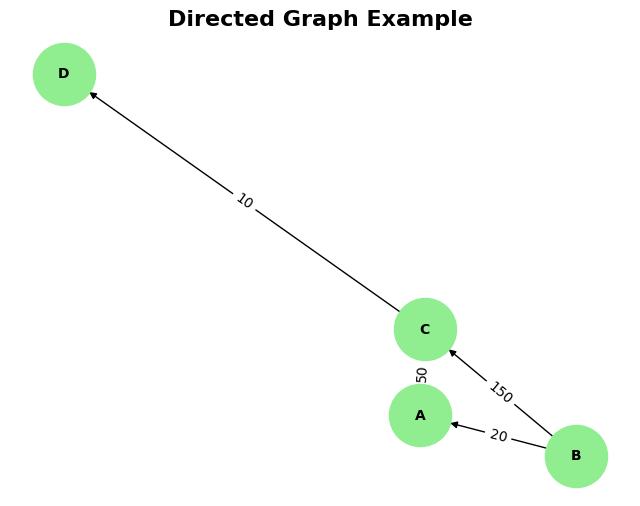

In [114]:
DG = nx.DiGraph()
DG.add_node("A")
DG.add_node("B")
DG.add_node("C")
DG.add_node("D")
DG.add_edge("B", "A", weight=20)
DG.add_edge("B", "C", weight=150)
DG.add_edge("A", "C", weight=50)
DG.add_edge("C", "D", weight=10)
 #plotar o grafo direcionado
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(8, 6))
pos = nx.spring_layout(DG, seed=42)
nx.draw(DG, pos, with_labels=True, node_color='lightgreen', node_size=2000, font_size=10, font_weight='bold', arrows=True)
edge_labels = nx.get_edge_attributes(DG, 'weight')
nx.draw_networkx_edge_labels(DG, pos, edge_labels=edge_labels)
plt.title('Directed Graph Example', fontsize=16, fontweight='bold')
plt.show()

In [115]:
# calculando a local reach centrality para os nós do grafo direcionado DG levando em conta o peso das arestas
local_reach_centrality_weighted = {node: nx.local_reaching_centrality(DG, node, weight='weight') for node in DG.nodes()}
pd.Series(local_reach_centrality_weighted).sort_values(ascending=False)

B    1.449275
A    0.463768
C    0.057971
D    0.000000
dtype: float64